In [11]:
import numpy as np
from pynn_brainscales import brainscales2 as pynn
from pynn_brainscales.brainscales2.morphology import create_mc_neuron, \
    Compartment, SharedLineConnection
from pynn_brainscales.brainscales2.standardmodels.cells import SpikeSourceArray
from pynn_brainscales.brainscales2.standardmodels.synapses import StaticSynapse
import quantities
from matplotlib import pyplot as plt

In [12]:
from dlens_vx_v3 import hxcomm
with hxcomm.ManagedConnection() as conn:
    print(conn.get_unique_identifier())

hxcube6fpga3chip66_1


In [13]:
from _static.common.helpers import setup_hardware_client
setup_hardware_client()

from _static.common.helpers import get_nightly_calibration
calib = get_nightly_calibration()

refractory_clock_scale = 7

for backend in calib.neuron_block.backends:
    backend.clock_scale_fast = refractory_clock_scale
    
period_refractory_clock = 1. / (250e6 / 2**(refractory_clock_scale + 1))
print(period_refractory_clock)

# setup PyNN and inject calibration data
pynn.setup(initial_config=calib)

1.024e-06


0 [<SpikeTrain(array([0.028408]) * ms, [0.0 ms, 0.08 ms])>]
1 [<SpikeTrain(array([0.005528]) * ms, [0.0 ms, 0.08 ms])>]
2 [<SpikeTrain(array([0.027024]) * ms, [0.0 ms, 0.08 ms])>]


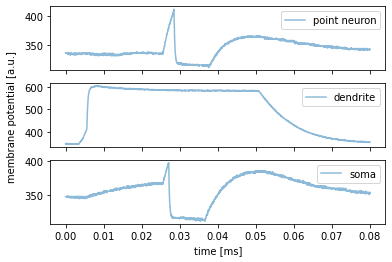

In [17]:
%matplotlib inline

all_neurons = pynn.Population(3, pynn.cells.HXNeuron(threshold_v_threshold=300))

ref_neuron = pynn.PopulationView(all_neurons, [0])
dendrite = pynn.PopulationView(all_neurons, [1])
soma = pynn.PopulationView(all_neurons, [2])
                                                                                                                                                             
dendrite.set(
    multicompartment_enable_conductance=True,
    multicompartment_i_bias_nmda=30,
    multicompartment_connect_soma_right=True,
    reset_v_reset=800,
    refractory_period_reset_holdoff=0,
    refractory_period_refractory_time=75,
)

ref_neuron.set(
    refractory_period_refractory_time=10,
)

soma.set(
    multicompartment_connect_soma=True,
    refractory_period_refractory_time=10,
)

wait_before_experiment = 0.003 * quantities.ms
isi = 1 * quantities.us
exc_spikes = wait_before_experiment + np.arange(5) * isi
exc_spikes = np.array(exc_spikes.rescale(quantities.ms))

exc_stim_pop = pynn.Population(2,
                               SpikeSourceArray(spike_times=exc_spikes))
exc_proj = pynn.Projection(exc_stim_pop, dendrite,
                           pynn.AllToAllConnector(),
                           synapse_type=StaticSynapse(weight=63),
                           receptor_type="excitatory")

asdf = pynn.Population(4,
                SpikeSourceArray(spike_times=[0.025]))
pynn.Projection(asdf, soma,
                pynn.AllToAllConnector(),
                synapse_type=StaticSynapse(weight=40),
                receptor_type="excitatory")
pynn.Projection(asdf, ref_neuron,
                pynn.AllToAllConnector(),
                synapse_type=StaticSynapse(weight=40),
                receptor_type="excitatory")

recorded_neurons = [0, 1, 2]
labels = ["point neuron", "dendrite", "soma"]
fig, axs = plt.subplots(len(recorded_neurons), 1, sharex="all")

for idx, neuron_id in enumerate(recorded_neurons):
    p_view = pynn.PopulationView(all_neurons, [neuron_id])
    p_view.record(["v", "spikes"])
    pynn.run(0.08)
    mem_v = p_view.get_data("v").segments[-1].irregularlysampledsignals[0]
    spikes = p_view.get_data("spikes").segments[-1].spiketrains
    print(idx, spikes)
    axs[idx].plot(mem_v.times, mem_v, alpha=0.5, label=labels[idx])
    axs[idx].legend()
    #axs[idx].set_ylim(100, 800)
    pynn.reset()
    all_neurons.record(None)

axs[-1].set_xlabel("time [ms]")
fig.text(0.025, 0.5, "membrane potential [a.u.]", va="center", rotation="vertical")
plt.savefig("excitatory_neuron.pdf")